In [53]:
import pandas as pd
import numpy as np
from pathlib import Path
import os

from preprocessor import Preprocessor
from data_plotter import DataPlotter

from models import BaseLinearModel, LinearModel, Ridge, Lasso

In [54]:
CWD = os.path.abspath('')

In [55]:
train_data_file = Path(CWD).parent / "data/train.csv"
test_data_file = Path(CWD).parent / "data/test.csv"

train_data, test_data = pd.read_csv(train_data_file), pd.read_csv(test_data_file)

train_preprocessor = Preprocessor(train_data)
test_preprocessor = Preprocessor(test_data)

data_plotter = DataPlotter()

Columns that contain nan values - ['fuel_type', 'accident', 'clean_title']


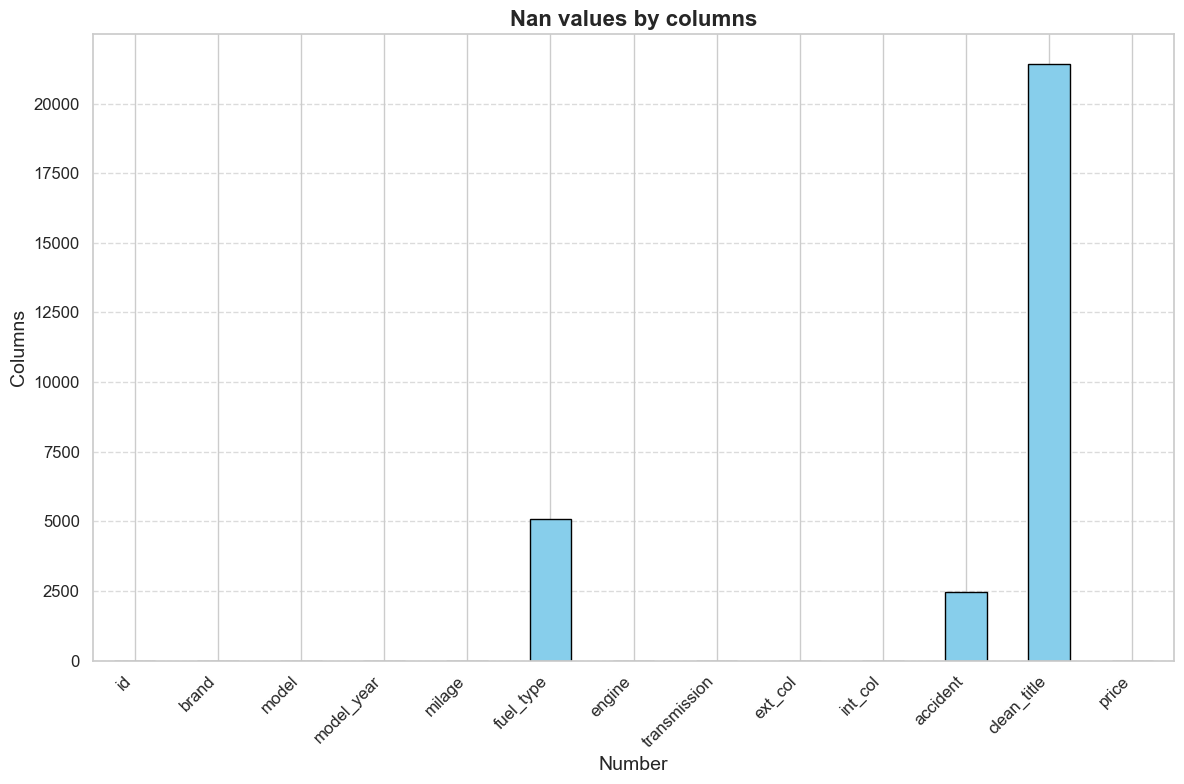

In [56]:
nan_columns = train_data.columns[train_data.isnull().sum() > 1]

print(f'Columns that contain nan values - {nan_columns.to_list()}')

data_plotter.plot_barchart(data=train_data.isnull().sum(), title="Nan values by columns", xlabel="Number", ylabel="Columns")

Unique values for fuel_type - ['Gasoline' 'E85 Flex Fuel' nan 'Hybrid' 'Diesel' 'Plug-In Hybrid' '–'
 'not supported']


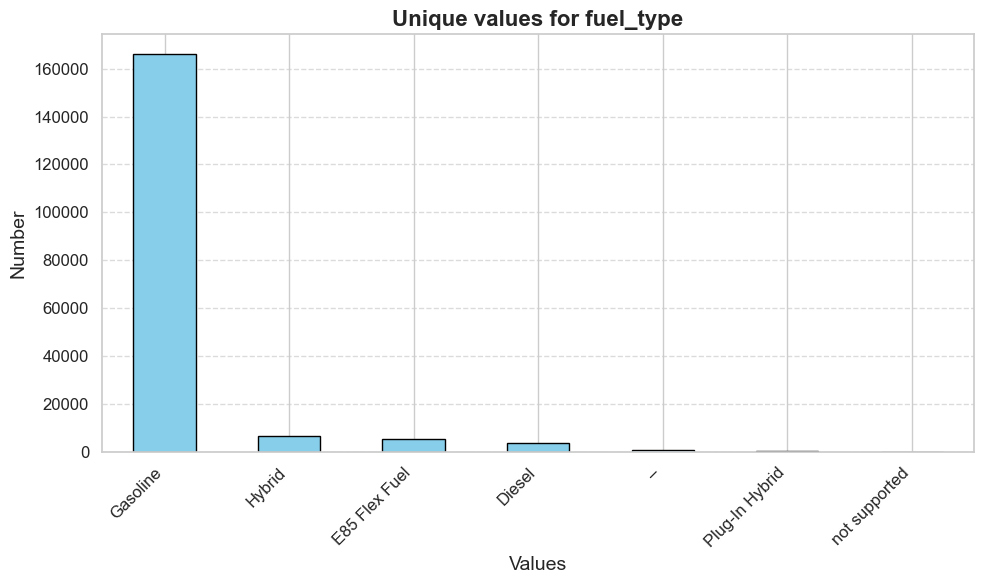

Unique values for accident - ['None reported' 'At least 1 accident or damage reported' nan]


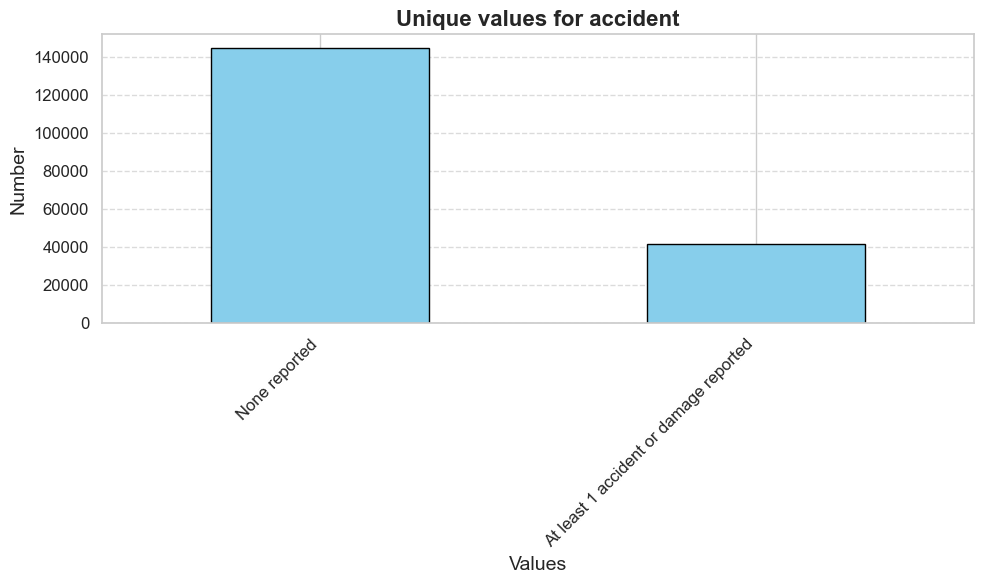

Unique values for clean_title - ['Yes' nan]


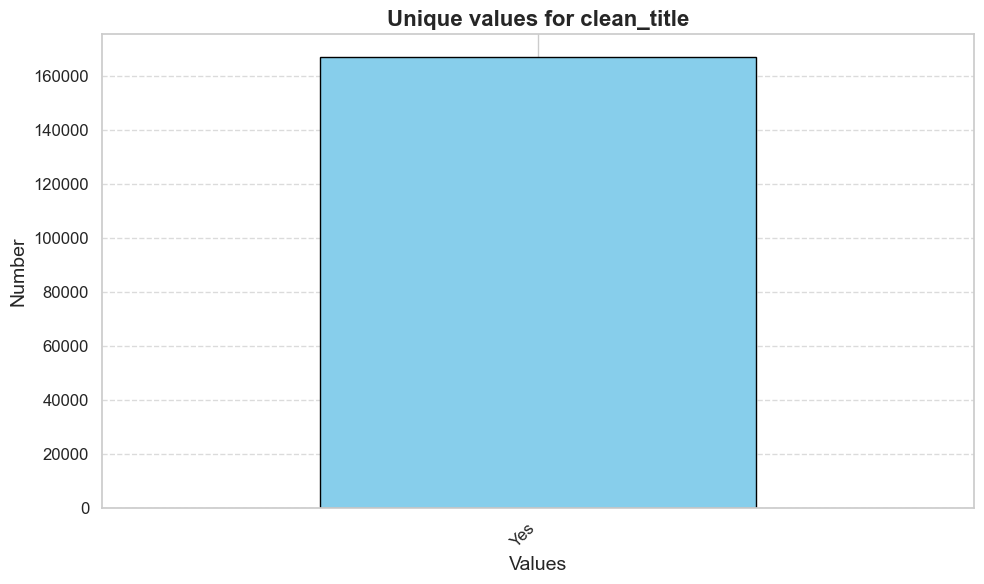

In [57]:
for column in nan_columns.to_list():
    print(f'Unique values for {column} - {train_data[column].unique()}')
    data_plotter.plot_barchart(
        data=train_data[column].value_counts(),
        title=f'Unique values for {column}',
        xlabel="Values",
        ylabel="Number",
        figsize=(10,6)
    )

/Users/denis/Desktop/unabomber/computational_DS/CDS_project/src/preprocessor/__init__.py:33: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  self.data[column].replace(self.mappers["value_to_nan_mappers"][column], np.nan, inplace=True)


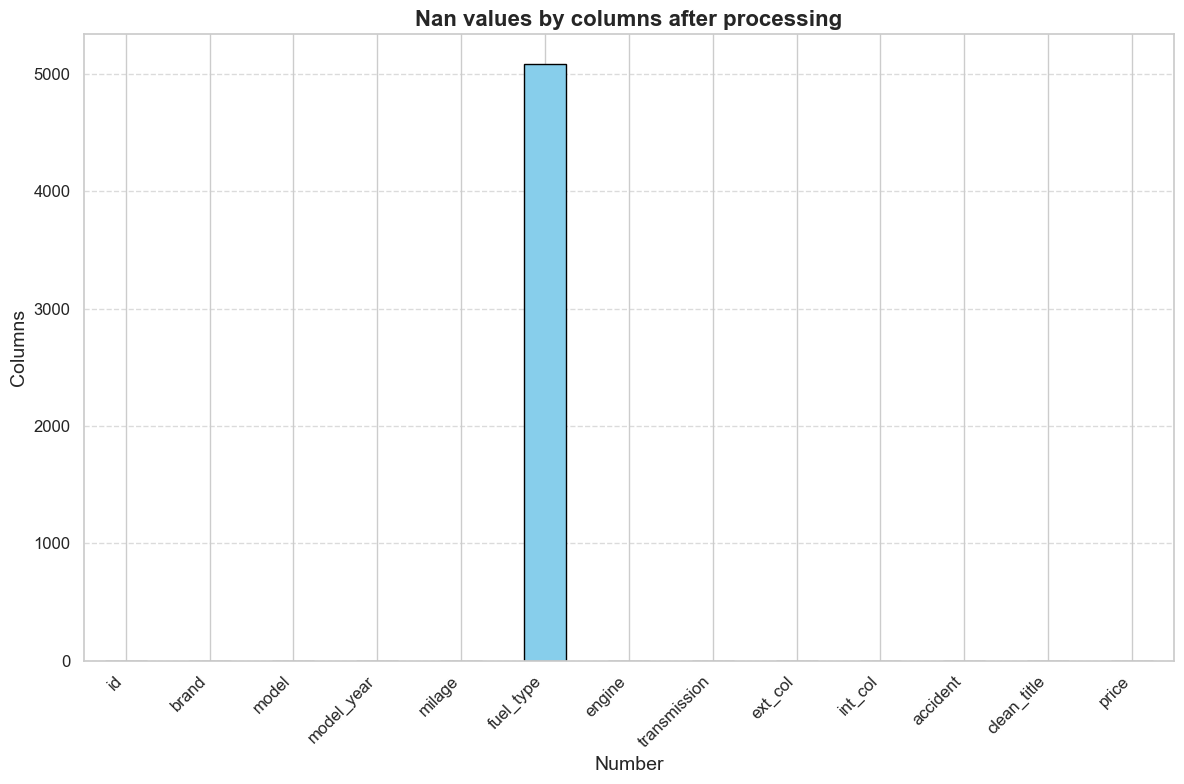

In [58]:
train_data = train_preprocessor.replace_nan_with_value(columns=["accident", "clean_title"])
train_data = train_preprocessor.replace_value_with_nan(columns=["fuel_type"])

data_plotter.plot_barchart(data=train_data.isnull().sum(), title="Nan values by columns after processing", xlabel="Number", ylabel="Columns")

In [59]:
train_data = train_preprocessor.fill_na_values(column="fuel_type")

/Users/denis/Desktop/unabomber/computational_DS/CDS_project/src/preprocessor/__init__.py:39: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  self.data[column].fillna(self.data[column].mode()[0], inplace=True)


In [60]:
train_data["engine"].value_counts()

engine
355.0HP 5.3L 8 Cylinder Engine Gasoline Fuel           3462
240.0HP 2.0L 4 Cylinder Engine Gasoline Fuel           2902
420.0HP 6.2L 8 Cylinder Engine Gasoline Fuel           2841
2.0L I4 16V GDI DOHC Turbo                             2680
375.0HP 3.5L V6 Cylinder Engine Gasoline Fuel          2451
                                                       ... 
151.0HP 1.5L 4 Cylinder Engine Gas/Electric Hybrid        1
184.0HP 2.4L 4 Cylinder Engine Flex Fuel Capability       1
78.0HP 1.2L 3 Cylinder Engine Gasoline Fuel               1
139.0HP 1.6L 4 Cylinder Engine Plug-In Electric/Gas       1
313.0HP 2.0L 4 Cylinder Engine Plug-In Electric/Gas       1
Name: count, Length: 1117, dtype: int64

In [61]:
train_data = train_preprocessor.create_new_features(column="engine")

# This is shit, like 22% is too much, will drop for now

In [62]:
train_data['fuel_mismatch'] = train_data['fuel_type'].str.lower() != train_data['fuel_type_from_engine'].str.lower()

mismatch_count = train_data['fuel_mismatch'].sum()
total_count = len(train_data)

print(f'Mismatched fuel types: {mismatch_count} out of {total_count} ({mismatch_count / total_count:.2%})')

for i in range(len(train_data)):
    if train_data["fuel_mismatch"].iloc[i] and train_data['fuel_type_from_engine'].iloc[i] is not None:
        print(f'{train_data['fuel_type'].iloc[i]}, {train_data['fuel_type_from_engine'].iloc[i]}')

Mismatched fuel types: 42880 out of 188533 (22.74%)
Gasoline, Electric
Hybrid, Gasoline
Hybrid, Gasoline
Gasoline, Electric
Gasoline, Diesel
Gasoline, Electric
Gasoline, Electric
Hybrid, Gasoline
Hybrid, Gasoline
Hybrid, Gasoline
Plug-In Hybrid, Electric
Gasoline, Electric
Gasoline, Electric
Gasoline, Electric
Gasoline, Electric
Hybrid, Gasoline
Gasoline, Electric
Plug-In Hybrid, Electric
Gasoline, Electric
Hybrid, Gasoline
Hybrid, Electric
Hybrid, Electric
Gasoline, Electric
Hybrid, Electric
Hybrid, Gasoline
Hybrid, Gasoline
Hybrid, Gasoline
Hybrid, Electric
Hybrid, Gasoline
Gasoline, Electric
Gasoline, Electric
Hybrid, Electric
Gasoline, Electric
Hybrid, Gasoline
Hybrid, Electric
Hybrid, Electric
Hybrid, Gasoline
Hybrid, Gasoline
Hybrid, Electric
Hybrid, Gasoline
Hybrid, Electric
Hybrid, Gasoline
Gasoline, Electric
Hybrid, Gasoline
Hybrid, Gasoline
Gasoline, Electric
Gasoline, Electric
Gasoline, Electric
Gasoline, Electric
Hybrid, Gasoline
Gasoline, Electric
Gasoline, Electric
Gasoli

In [63]:
train_data = train_data[~train_data['fuel_mismatch']].reset_index(drop=True)

train_data = train_data.drop(columns=["fuel_mismatch"])

train_data = train_data.assign(fuel_type=train_data["fuel_type_from_engine"]).drop(columns=["fuel_type_from_engine"])

In [64]:
train_data = train_data.dropna(axis=1)
train_data.isnull().sum()
train_data.dtypes

id               int64
brand           object
model           object
model_year       int64
milage           int64
fuel_type       object
engine          object
transmission    object
ext_col         object
int_col         object
accident        object
clean_title     object
price            int64
dtype: object

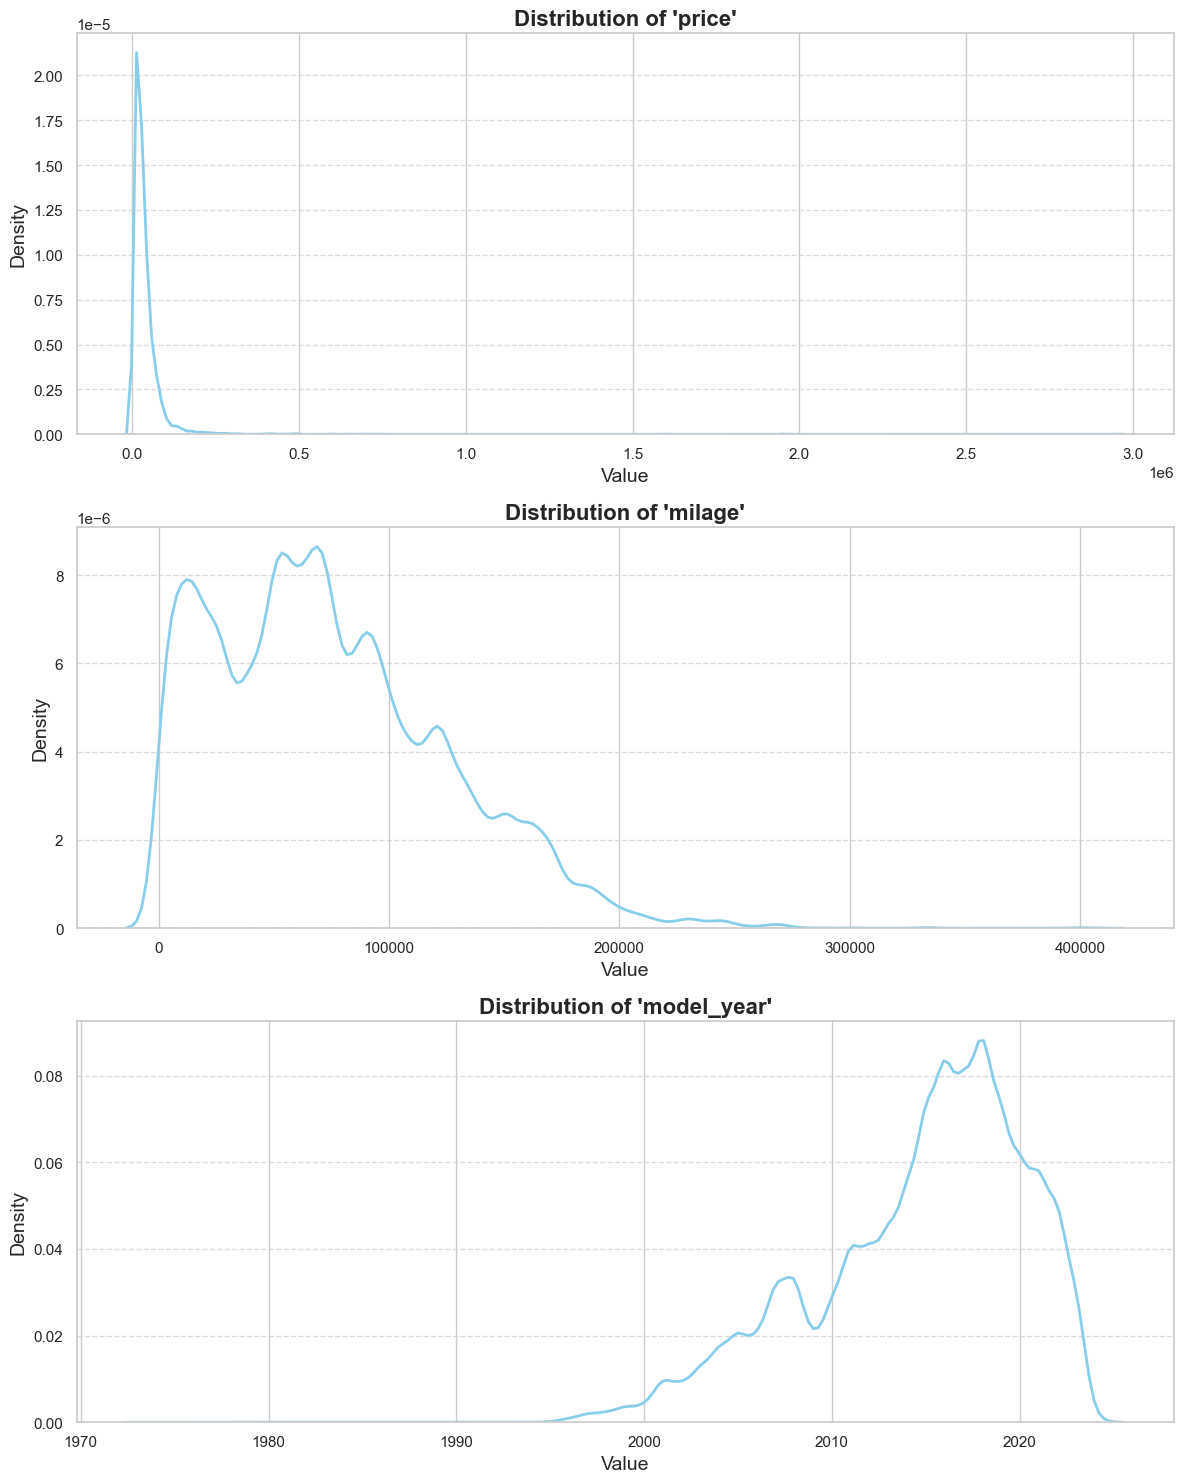

In [65]:
data_plotter.plot_numerical_distribution(data=train_data, columns=["price", "milage", "model_year"])

In [66]:
ctg_modes = {}
for column in train_data.columns:
    if train_data[column].dtype == "int64":
        continue
    if len(train_data[column].unique()) <= 10:
        mode = "one_hot"
    else:
        mode = "default"

    ctg_modes[column] = mode

train_data = Preprocessor(train_data).transform_ctg_to_num(categories=ctg_modes)
train_data.head()

columns = []
data_plotter.default_configs.color = "red"
for column in train_data.columns:
    if train_data[column].dtype == "int64":
        columns.append(column)

train_data.head()

,id,brand,model,model_year,milage,engine,transmission,ext_col,int_col,price,fuel_type_Diesel,fuel_type_E85 Flex Fuel,fuel_type_Gasoline,fuel_type_Hybrid,accident_At least 1 accident or damage reported,accident_None reported,clean_title_No,clean_title_Yes
0,0,30,479,2007,213000,86,33,156,46,4200,False,False,True,False,False,True,False,True
1,1,27,901,2002,143250,270,33,130,7,4999,False,False,True,False,True,False,False,True
2,2,8,1505,2002,136731,480,33,21,46,13900,False,True,False,False,False,True,False,True
3,3,15,738,2017,19500,659,43,15,8,45000,False,False,True,False,False,True,False,True
4,4,35,1044,2021,7388,178,20,15,7,97500,False,False,True,False,False,True,False,True
